In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random



from FEM import *
from octotruss import *
from Dataset import *

# Initialize mesh

Elements :  688
Nodes :  163


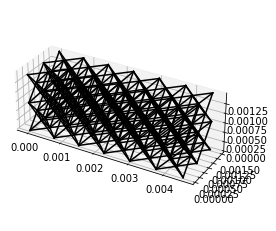

In [2]:
nx, ny, nz = 6,2,2
l = 530e-6
d = 65e-6

coords, conn = octo_truss(l,nx,ny,nz)



Nnodes = len(coords)
Nel = len(conn)


areas = np.pi*d**2/4*np.ones((Nel,1))


p0=np.array([1,1,1])

plot_truss(coords, conn, aspect=(nx,ny,nz))

print("Elements : ", Nel)
print("Nodes : ", Nnodes)

# Initialize constitutive law

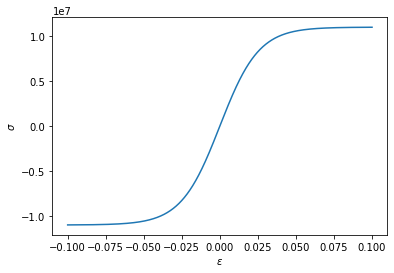

In [3]:
E = 430e6
Ep = 0
Ce = E
max_sigma = 11e6

sigma_law = lambda epsi : Ep*E*epsi+max_sigma*np.tanh( (1-Ep)*E/max_sigma*epsi)

epsi_law = lambda s : max_sigma/E*np.arctanh(s/max_sigma)

Elaw = lambda epsi :Ep*E + (1-Ep)*E*(1-np.tanh( (1-Ep)*E/max_sigma*epsi)**2)




x = np.linspace(-0.1,0.1,10000)
plt.figure()
plt.plot(x, sigma_law(x))

plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')
plt.show()

2700


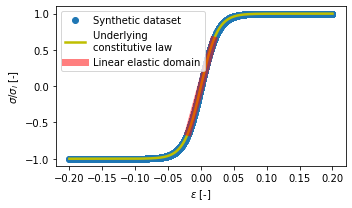

In [4]:
# Create a dataset by sampling along sigma in the stiff zone and along epsilon for the soft zone

multi = 100
Ndatax = 15*multi
Ndatay= 12*multi
Ndata = Ndatax+Ndatay
print(Ndata)
max_epsi = 0.2
noise_s = 0
noise_e = 0

sigma_l = 7e6
#sigma_l = 200

transition = 275/300*max_sigma

DBsigmas1 = np.linspace(0,transition,Ndatay)
DBepsis1 = epsi_law(DBsigmas1)

DBepsis2 = np.linspace(np.max(DBepsis1)+max_epsi/(Ndata),max_epsi,Ndatax)
DBsigmas2 = sigma_law(DBepsis2)

DBsigmas = np.hstack([DBsigmas1,DBsigmas2])
DBepsis = np.hstack([DBepsis1,DBepsis2])

DBsigmas = np.hstack([-DBsigmas[::-1],DBsigmas[1:]])
DBepsis = np.hstack([-DBepsis[::-1],DBepsis[1:]])

dataset = np.array([[e+random.gauss(0,noise_e),s+random.gauss(0,noise_s)] for e,s in zip(DBepsis,DBsigmas)])


x = np.linspace(-max_epsi,max_epsi,1000)



plt.figure(figsize=(5,3))
plt.plot(dataset[:,0], dataset[:,1]/max_sigma, '.', color='tab:blue', label="Synthetic dataset", markersize=12)
plt.plot(x, sigma_law(x)/max_sigma, 'y', lw=2.5, label="Underlying \nconstitutive law")
plt.plot([-epsi_law(sigma_l),epsi_law(sigma_l)],[-sigma_l/max_sigma,sigma_l/max_sigma],'r-', lw=7, alpha=0.5, label="Linear elastic domain")
plt.xlabel('$\epsilon$ [-]')
plt.ylabel('$\sigma/\sigma_l$ [-]')
plt.tight_layout()
plt.legend()
plt.savefig('dataset.pdf',bbox_inches="tight")
plt.show()



# Boundary Condition

In [5]:
# Return the BC functor for a given displacement d
# Apply a displacement on the nodes at the center top of the beam

def applyBC_d(coords, conn, d):
    
    def applyBC(coords,conn):
        blocked_DOF = np.zeros_like(coords)
        u = np.zeros_like(coords).astype('float')

        for i, p in enumerate(coords):
            if p[0]<10e-5 and p[2]<10e-5:
                blocked_DOF[i,:] = True
                
            if p[0]>nx*l*np.sqrt(2)-10e-5 and p[2]<10e-5:
                blocked_DOF[i,:] = True

            if  (p[0] > (nx-0.1)*np.sqrt(2)*l/2 
                 and p[0] < (nx+0.1)*np.sqrt(2)*l/2
                 and p[2]>nz*l*np.sqrt(2)-0.1*l):
                blocked_DOF[i,:] = True
                u[i,2] = -d
                
        #blocked_DOF[:,1]= True
    
        blocked_DOF = blocked_DOF.ravel().astype('bool')
        u = u.ravel()

        free_DOF = get_free(blocked_DOF)

        F = np.zeros_like(coords).astype('float')
        F = F.ravel()

        return blocked_DOF, free_DOF, u, F 
    return applyBC


## Linear Solve

In [6]:
applyBC=applyBC_d(coords, conn, 0.4*l)
blocked_DOF, free_DOF, u, F = applyBC(coords, conn)

K = compute_K(coords, conn, areas, E)

u=solve_static(K,u,F,blocked_DOF)
F=K.dot(u)

# Mask of the points where the displacement is imposed
mask = np.logical_and(np.isclose(coords[:,0], l*3*np.sqrt(2)),np.isclose(coords[:,2], l*2*np.sqrt(2)))
load = np.sum(F.reshape((-1,3))[mask], axis = 0)[2]
print("Simulated load response : ", load)

u_lin = u.copy()

Simulated load response :  -0.45601175072062694


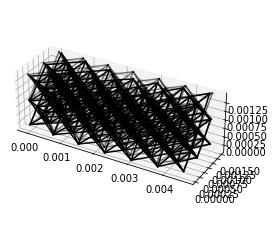

In [7]:
plot_truss(coords,conn, u.reshape((-1,3)), duplicate=True, aspect=(nx,ny,nz))

# Newton Raphson Solve

In [8]:
%%time
applyBC=applyBC_d(coords, conn, 0.4*l)
blocked_DOF, free_DOF, u, F = applyBC(coords, conn)


u,F= NR(coords,conn, areas, sigma_law, Elaw, u,F, free_DOF, max_iter=100)

load = np.sum(F.reshape((-1,3))[mask], axis = 0)[2]
print("Simulated load response : ", load)

Succesfull converge in 5  steps
Simulated load response :  -0.2579971535243555
CPU times: user 19.4 s, sys: 8.05 s, total: 27.4 s
Wall time: 7.74 s


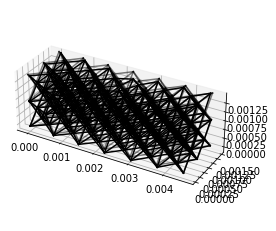

In [9]:
plot_truss(coords,conn, u.reshape((-1,3)), duplicate=True, aspect=(nx,ny,nz))

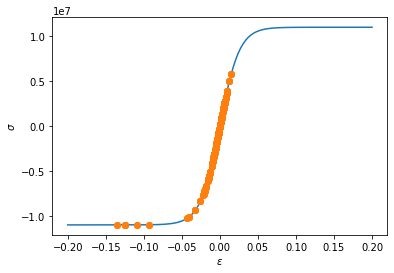

In [10]:

B, _ = compute_B_and_weights(coords,conn,areas)

plt.figure()
plt.plot(x, sigma_law(x))
plt.plot(B.dot(u), sigma_law(B.dot(u)),'o')
plt.xlabel("$\epsilon$")
plt.ylabel("$\sigma$")
plt.show()

# Pure DD

In [11]:
%%time
orderDP = Dataset(dataset, E)

CPU times: user 233 ms, sys: 1.17 ms, total: 235 ms
Wall time: 233 ms


In [12]:
%%time
applyBC=applyBC_d(coords, conn, 0.4*l)

isDD = np.ones((len(conn),1)).ravel()
isDD = isDD.astype('bool')

u, F, comp, guess, eta = solve_DD(coords, conn, areas, E, isDD, orderDP, applyBC, max_iter = 1000)

load = np.sum(F.reshape((-1,3))[mask], axis = 0)[2]
print("Simulated load response : ", load)

Succesfull convergence in  346  steps
Simulated load response :  -0.2651939239130935
CPU times: user 18.8 s, sys: 43.8 s, total: 1min 2s
Wall time: 14.3 s


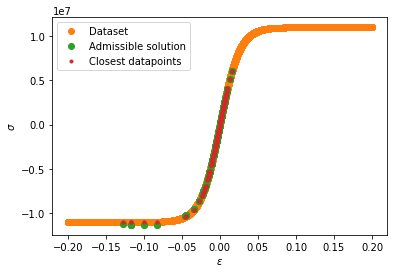

In [13]:
plt.figure()
plt.plot(x, sigma_law(x))
plt.plot(dataset[:,0], dataset[:,1], 'o', label="Dataset")
plt.plot(comp[:,0], comp[:,1],'o', label="Admissible solution")
plt.plot(guess[:,0], guess[:,1],'.', label="Closest datapoints")
plt.xlabel("$\epsilon$")
plt.ylabel("$\sigma$")
plt.legend()
plt.show()

# D-refinement

In [14]:
%%time
applyBC=applyBC_d(coords, conn, 0.4*l)
blocked_DOF, free_DOF, u, F = applyBC(coords, conn)
isDD = np.zeros((len(conn),1)).ravel()
isDD = isDD.astype('bool')
u, F, comp, guess, eta, isDD = solve_DD_drefine(coords, conn, areas, E, orderDP, sigma_l, 
                                                applyBC, isDD=isDD)

load = np.sum(F.reshape((-1,3))[np.logical_and(np.isclose(coords[:,0], l*3*np.sqrt(2)),np.isclose(coords[:,2], l*2*np.sqrt(2)))][:,2])
print("Simulated load response : ", load)

Succesfull convergence in  0  steps
120  element(s) have been refined
Succesfull convergence in  370  steps
Refinement complete after  1  steps.
120 DD driven elements for a total of  688  elements
Simulated load response :  -0.2631473822192255
CPU times: user 9.94 s, sys: 21.3 s, total: 31.3 s
Wall time: 7.47 s


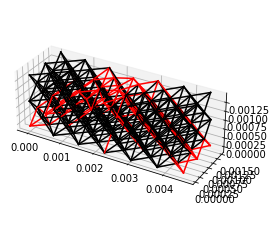

In [15]:
plot_truss(coords, conn, u.reshape((-1,3)), isDD=isDD, aspect=(nx,ny,nz))

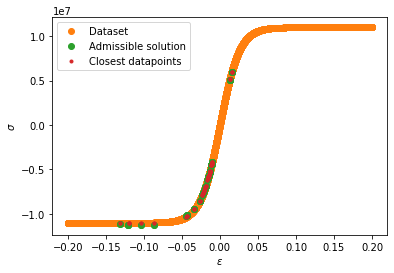

In [16]:
plt.figure()
plt.plot(x, sigma_law(x))
plt.plot(dataset[:,0], dataset[:,1], 'o', label="Dataset")
plt.plot(comp[:,0], comp[:,1],'o', label="Admissible solution")
plt.plot(guess[:,0], guess[:,1],'.', label="Closest datapoints")
plt.xlabel("$\epsilon$")
plt.ylabel("$\sigma$")
plt.legend()



# Incremental loading

In [17]:
ds = np.linspace(0,0.4*l,21)
B, weigths = compute_B_and_weights(coords,conn,areas)

mask = np.logical_and(np.isclose(coords[:,0], l*3*np.sqrt(2)),np.isclose(coords[:,2], l*2*np.sqrt(2)))

In [18]:
%%time 

load_nr = []
isLargelist = []
for d in ds:
    
    print("--== d ",d," ==--")
    
    applyBC=applyBC_d(coords, conn, d)
    
    blocked_DOF, free_DOF, u, F = applyBC(coords, conn)
    if d==0:
        u_nr = u.copy()
    else:
        u_nr[blocked_DOF]=u[blocked_DOF]
    
    try:
        
        u,F= NR(coords,conn, areas, sigma_law, Elaw, u_nr,F, free_DOF)
       
        load = np.sum(F.reshape((-1,3))[mask][:,2])
       
        load_nr.append(load.copy())
        u_nr = u.copy()
    except:
        print("NR bugged here")
        load_nr.append(0)
        u_nr = 0*u_nr
        
        
    epsi = B.dot(u)
    isLarge = np.abs(epsi)>sigma_l/E
    isLargelist.append(isLarge.copy())
    

load_nr = -np.array(load_nr)

--== d  0.0  ==--
Succesfull converge in 0  steps
--== d  1.06e-05  ==--
Succesfull converge in 3  steps
--== d  2.12e-05  ==--
Succesfull converge in 3  steps
--== d  3.18e-05  ==--
Succesfull converge in 4  steps
--== d  4.24e-05  ==--
Succesfull converge in 4  steps
--== d  5.3e-05  ==--
Succesfull converge in 4  steps
--== d  6.36e-05  ==--
Succesfull converge in 4  steps
--== d  7.42e-05  ==--
Succesfull converge in 4  steps
--== d  8.48e-05  ==--
Succesfull converge in 4  steps
--== d  9.54e-05  ==--
Succesfull converge in 4  steps
--== d  0.000106  ==--
Succesfull converge in 4  steps
--== d  0.0001166  ==--
Succesfull converge in 4  steps
--== d  0.0001272  ==--
Succesfull converge in 4  steps
--== d  0.0001378  ==--
Succesfull converge in 4  steps
--== d  0.0001484  ==--
Succesfull converge in 3  steps
--== d  0.00015900000000000002  ==--
Succesfull converge in 3  steps
--== d  0.0001696  ==--
Succesfull converge in 3  steps
--== d  0.0001802  ==--
Succesfull converge in 2  st

In [19]:
%%time 
initial_guess=None
load_dd = []
for d in ds:
    
    print("--== d ",d," ==--")
    applyBC=applyBC_d(coords, conn, d)
    

    isDD = np.ones((len(conn),1)).ravel()
    isDD = isDD.astype('bool')
    u, F, comp, guess, eta = solve_DD(coords, conn, areas, E, isDD, orderDP, applyBC, initial_guess=None)
    initial_guess=guess
    load = np.sum(F.reshape((-1,3))[mask][:,2])
    load_dd.append(load)
    u_dd = u.copy()
    
guess_DD = guess.copy()
u_DD = u.copy()
load_dd = -np.array(load_dd)

--== d  0.0  ==--
Succesfull convergence in  1  steps
--== d  1.06e-05  ==--
Succesfull convergence in  8  steps
--== d  2.12e-05  ==--
Succesfull convergence in  9  steps
--== d  3.18e-05  ==--
Succesfull convergence in  10  steps
--== d  4.24e-05  ==--
Succesfull convergence in  9  steps
--== d  5.3e-05  ==--
Succesfull convergence in  10  steps
--== d  6.36e-05  ==--
Succesfull convergence in  10  steps
--== d  7.42e-05  ==--
Succesfull convergence in  12  steps
--== d  8.48e-05  ==--
Succesfull convergence in  13  steps
--== d  9.54e-05  ==--
Succesfull convergence in  13  steps
--== d  0.000106  ==--
Succesfull convergence in  17  steps
--== d  0.0001166  ==--
Succesfull convergence in  22  steps
--== d  0.0001272  ==--
Succesfull convergence in  29  steps
--== d  0.0001378  ==--
Succesfull convergence in  41  steps
--== d  0.0001484  ==--
Succesfull convergence in  52  steps
--== d  0.00015900000000000002  ==--
Succesfull convergence in  83  steps
--== d  0.0001696  ==--
Succesfu

In [20]:
%%time 
load_cr = []
nSwitch = []

u_cr_list = []

isDDlist = [np.zeros((len(conn),1)).ravel().astype('bool')]

for d in ds:
    
    print("--== d ",d," ==--")
    applyBC=applyBC_d(coords, conn, d)
    

    u, F, comp, guess, eta, isDD = solve_DD_drefine(coords, conn, areas, 
                                                    E, orderDP, sigma_l, applyBC, isDD=isDDlist[-1])
    load = np.sum(F.reshape((-1,3))[mask][:,2])
    load_cr.append(load)
    
    isDDlist.append(isDD.copy())
    nSwitch.append(np.sum(isDD))
    u_cr = u.copy()
    u_cr_list.append(u_cr.copy())
    
    
 
guess_DR = guess.copy()
u_DR = u.copy()
isDDlist = isDDlist[1:]
load_cr = -np.array(load_cr)
nSwitch = np.array(nSwitch)

--== d  0.0  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  1.06e-05  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  2.12e-05  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  3.18e-05  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  4.24e-05  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  5.3e-05  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  6.36e-05  ==--
Succesfull convergence in  0  steps
2  element(s) have been refined
Succesfull convergence in  2  ste

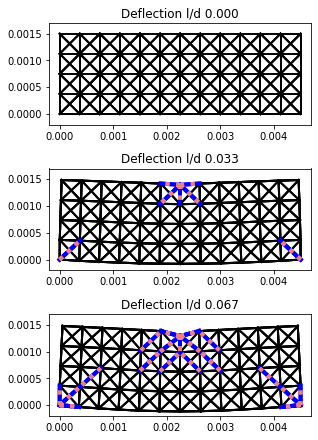

In [22]:
multi=1
fig = plt.figure(figsize=(5,8))

for i,step in  enumerate([0,10,-1]): #enumerate([0,1,2]): #
    
    disp = u_cr_list[step].reshape((-1,3))
    isDD = isDDlist[step]
    isLarge = isLargelist[step]

    fax = fig.add_subplot(411+i, aspect='equal')


    plt.xlim((-0.0002,np.max(coords[:,0])+0.0002))
    plt.ylim((-0.0002, np.max(coords[:,1])+0.0002))
    for e,bar in enumerate(conn[isDD==False]):
        
        plt.title("Deflection l/d {0:.3f}".format(ds[step]/6/l))
        barcoords = coords[bar]
        bardisp = disp[bar]*multi


        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], 'k', lw=2)



    for e,bar in enumerate(conn[isDD]):
        barcoords = coords[bar]
        bardisp = disp[bar]*multi

        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], color = 'blue', lw=4)
        
        
    for e,bar in enumerate(conn[isLarge]):
        barcoords = coords[bar]
        bardisp = disp[bar]*multi

        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], linestyle='dotted', 
                 color="lightcoral", alpha=0.9, lw=4)
        
plt.tight_layout()
#plt.savefig('truss.png',bbox_inches="tight", dpi=1000)
#plt.savefig('truss_21steps.pdf',bbox_inches="tight")

In [23]:
%%time 
load_crbis = []
nSwitchbis = []
dsbis = np.linspace(0,0.4*l,3)
u_cr_listbis = []

isDDlistbis = [np.zeros((len(conn),1)).ravel().astype('bool')]

for d in dsbis:
    
    print("--== d ",d," ==--")
    applyBC=applyBC_d(coords, conn, d)
    

    u, F, comp, guess, eta, isDD = solve_DD_drefine(coords, conn, areas, 
                                                    E, orderDP, sigma_l, applyBC, isDD=isDDlistbis[-1])
    load = np.sum(F.reshape((-1,3))[mask][:,2])
    load_crbis.append(load)
    
    isDDlistbis.append(isDD.copy())
    nSwitchbis.append(np.sum(isDD))
    u_cr = u.copy()
    u_cr_listbis.append(u_cr.copy())
    
    
    
isDDlistbis = isDDlistbis[1:]
load_crbis = -np.array(load_crbis)
nSwitchbis = np.array(nSwitchbis)

--== d  0.0  ==--
Succesfull convergence in  0  steps
Refinement complete after  0  steps.
0 DD driven elements for a total of  688  elements
--== d  0.000106  ==--
Succesfull convergence in  0  steps
20  element(s) have been refined
Succesfull convergence in  16  steps
Refinement complete after  1  steps.
20 DD driven elements for a total of  688  elements
--== d  0.000212  ==--
Succesfull convergence in  69  steps
52  element(s) have been refined
Succesfull convergence in  380  steps
Refinement complete after  1  steps.
72 DD driven elements for a total of  688  elements
CPU times: user 10.5 s, sys: 20.4 s, total: 31 s
Wall time: 4.97 s


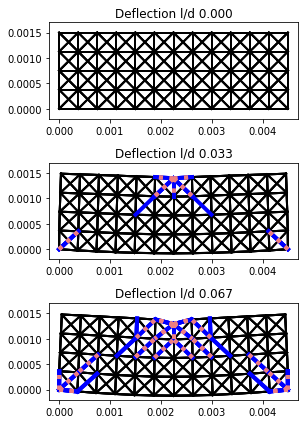

In [24]:
multi=1
fig = plt.figure(figsize=(5,6))
convert = [0,10,-1]
for i,step in enumerate([0,1,2]): #
    
    disp = u_cr_listbis[step].reshape((-1,3))
    isDD = isDDlistbis[step]
    isLarge = isLargelist[convert[i]]

    fax = fig.add_subplot(311+i, aspect='equal')


    plt.xlim((-0.0002,np.max(coords[:,0])+0.0002))
    plt.ylim((-0.0002, np.max(coords[:,1])+0.0002))
    for e,bar in enumerate(conn[isDD==False]):
        
        plt.title("Deflection l/d {0:.3f}".format(dsbis[step]/6/l))
        barcoords = coords[bar]
        bardisp = disp[bar]*multi


        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], 'k', lw=2)



    for e,bar in enumerate(conn[isDD]):
        barcoords = coords[bar]
        bardisp = disp[bar]*multi

        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], color = 'blue', lw=4)
        
        
    for e,bar in enumerate(conn[isLarge]):
        barcoords = coords[bar]
        bardisp = disp[bar]*multi

        plt.plot(barcoords[:,0]+bardisp[:,0],barcoords[:,2]+bardisp[:,2], linestyle='dotted', 
                 color="lightcoral", alpha=0.9, lw=4)
        
plt.tight_layout()
#plt.savefig('truss_3steps.pdf',bbox_inches="tight")

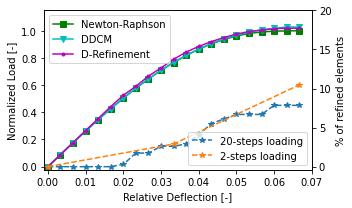

In [25]:
fig, ax1 = plt.subplots(figsize=(5,3))
color = 'k'
ax1.plot(ds/6/l, load_nr/max(load_nr), 'gs-', label="Newton-Raphson")
ax1.plot(ds/6/l, load_dd/max(load_nr), 'cv-', label="DDCM")
ax1.plot(ds/6/l, load_cr/max(load_nr), 'm.-', label="D-Refinement")
ax1.set_xlabel('Relative Deflection [-]')
ax1.set_ylabel('Normalized Load [-]', color=color)
ax1.set_ylim((-0.023,1.15))
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.xlim((-0.001,0.07))
color = 'k' #'tab:blue'
ax2.set_ylabel('% of refined elements', color=color)  
ax2.plot(ds/6/l, 100*nSwitch/Nel, '*--', label="20-steps loading")
ax2.plot(dsbis/6/l, 100*nSwitchbis/Nel, '*--', label="2-steps loading")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim((-0.4,20))
fig.tight_layout() 
plt.legend(loc='lower right')

#plt.savefig('load-deflection_21-1000.pdf',bbox_inches="tight")
plt.show()